## Tutorial on how to implement periodic boundaries

This tutorial will show how to implement Periodic boundary conditions (where particles that leave the domain on one side enter again on the other side) can be implemented in Parcels

The idea in Parcels is to do two things:
1) Extend the grid with a small 'halo'
2) Add a periodic boundary kernel to the `.execute`

We'll start by importing the relevant modules

In [1]:
from parcels import Grid, JITParticle
from parcels import AdvectionRK4
import numpy as np
from datetime import timedelta as delta
from scripts import *

We import the Peninsula grid, and then note down the first and last longitude (we will need them later)

In [2]:
grid = Grid.from_nemo('Peninsula_data/peninsula')
print grid.U.lon[0], grid.U.lon[-1]

0.00449964 0.895428


Extending the grid with a halo is very simply done using the `add_periodic_halo()` method. Halos can be added either in the zonal direction, the meridional direction, or both, by setting `zonal` and/or `meridional` to `True`

In [3]:
grid.add_periodic_halo(zonal=True)

The other item we need is a custom Kernel that can move the particle from one side of the domain to the other. Fot this we use `math.fmod` (note not to use the `%` operator, as in C this is only defined for integers, so will cause errors during JIT compilation).

To accurately place the particle if it has gone beyond one domain boundary, we currently have to explicitly use the values of `grid.U.lon[0]` and `grid.U.lon[-1]` (which is why we noted them above). *This will be fixed once Parcels gets capability for defining `Constants` on the grid.*

In [4]:
def periodicBC(particle, grid, time, dt):
    particle.lon = math.fmod(particle.lon - 0.00449964, 0.895428 - 0.00449964) + 0.00449964

Now define a particle set and execute it as usual

In [5]:
pset = grid.ParticleSet(10, pclass=JITParticle, start=(0.7, 0.1), finish=(0.7, 0.4))
output_file = pset.ParticleFile(name="PeriodicParticle")
pset.execute(AdvectionRK4 + pset.Kernel(periodicBC), 
             runtime=delta(hours=24), dt=delta(minutes=5), 
             interval=delta(hours=1), output_file=output_file)

Compiled JITParticleAdvectionRK4periodicBC ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gn/T/parcels-501/e314053eec65b2ef80b5495b2134f745.so


And finally plot the particle trajectories

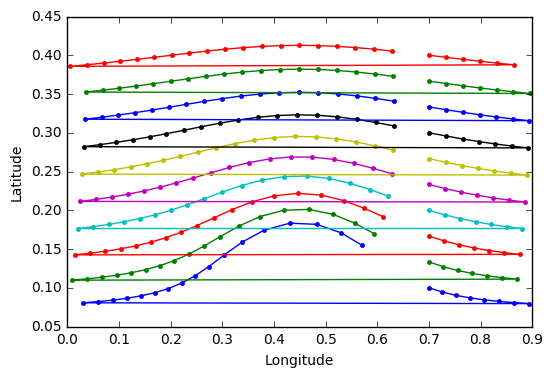

In [6]:
plotTrajectoriesFile('PeriodicParticle.nc')

We can see that the particles start at 0.7E, move eastward, and once they hit the boundary at 0.895428E, they jump to the other side of the domain (the horizontal lines). So we have periodic boundary conditions!

*As a note, one may ask why we need the halo. Why can't we use simply the `PeriodicBC` kernel? This is because, if the particle is close to the edge of the grid (but still in it), `AdvectionRK4` will need to interpolate velocities that may lay outside the grid domain. With the halo, we make sure `AdvectionRK4` can access these values.*